# CLothing Similarity Prototype

Most basic image similarity search possible

## Dataset
* https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset
## References
* https://www.kaggle.com/code/quadeer15sh/visually-similar-product-recommendation
* https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html
* https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py
* https://www.analyticsvidhya.com/blog/2021/06/transfer-learning-using-vgg16-in-pytorch/



In [2]:
import random 
import os
import numpy as np 
import pandas as pd 
import torch
from torch import nn 
from torchvision import models, transforms

In [3]:
data_dir = "/mnt/c/Users/james/Downloads/kaggle_clothing/fashion-dataset/"

In [4]:
images_df = pd.read_csv(data_dir+"images.csv")

In [5]:
images_df.size

88892

In [6]:
styles_df = pd.read_csv(data_dir+"styles.csv",
    on_bad_lines="skip")

In [7]:
styles_df["filename"] = styles_df["id"].astype(str)+".jpg"

In [8]:
image_files = os.listdir(data_dir+"images")

In [9]:
styles_df["present"] = styles_df["filename"].apply(
    lambda x: x in image_files
)

In [10]:
styles_df["present"].value_counts()

present
True     44419
False        5
Name: count, dtype: int64

In [11]:
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,present
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,True
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg,True
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,True
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg,True


## View Images

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
def show(imgs):
    if not isinstance(imgs,list):
        imgs=[imgs]
    fig, axs = plt.subplots(ncols=len(imgs),squeeze=False)
    for i, img in enumerate(imgs):
        img=img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0,i].imshow(np.asarray(img))
        axs[0,i].set(xticklabels=[], yticklabels=[],xticks=[],yticks=[])

In [14]:
! ls /mnt/c/Users/james/Downloads/kaggle_clothing/fashion-dataset/images

10000.jpg  17434.jpg  24849.jpg  32603.jpg  4049.jpg   48530.jpg  56617.jpg
10001.jpg  17435.jpg  2485.jpg	 32604.jpg  40493.jpg  48531.jpg  56618.jpg
10002.jpg  17436.jpg  24850.jpg  32605.jpg  40494.jpg  48532.jpg  56619.jpg
10003.jpg  17437.jpg  24853.jpg  32606.jpg  40495.jpg  48533.jpg  5662.jpg
10004.jpg  17438.jpg  24854.jpg  32607.jpg  40496.jpg  48535.jpg  56620.jpg
10005.jpg  17439.jpg  24855.jpg  32608.jpg  40498.jpg  48536.jpg  56622.jpg
10006.jpg  17440.jpg  24858.jpg  32609.jpg  40499.jpg  48537.jpg  56624.jpg
10007.jpg  17441.jpg  2486.jpg	 3261.jpg   4050.jpg   48539.jpg  56626.jpg
10008.jpg  17442.jpg  24866.jpg  32610.jpg  40500.jpg  4854.jpg   56627.jpg
10009.jpg  17443.jpg  24867.jpg  32611.jpg  40501.jpg  48541.jpg  56631.jpg
10010.jpg  17444.jpg  24868.jpg  32612.jpg  40502.jpg  48544.jpg  56632.jpg
10011.jpg  17445.jpg  24869.jpg  32613.jpg  40503.jpg  48548.jpg  56634.jpg
10012.jpg  17446.jpg  2487.jpg	 32614.jpg  40504.jpg  48549.jpg  56638.jpg
10013.jpg  17447

In [15]:
styles_df.columns.values

array(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName',
       'filename', 'present'], dtype=object)

In [16]:
from torchvision.io import read_image 
from torchvision.utils import make_grid 

img1 = read_image(data_dir+"images/"+styles_df["filename"].iloc[0])
img2 = read_image(data_dir+"images/"+styles_df["filename"].iloc[1])
grid = make_grid([img1, img2])


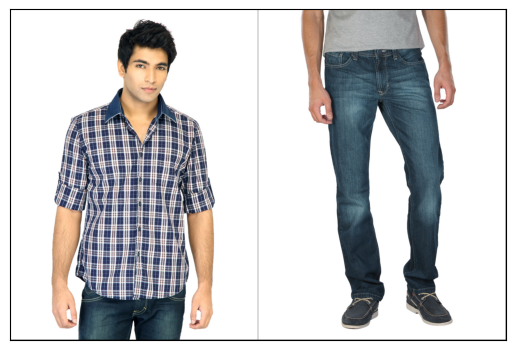

In [17]:
show(grid)

## Load & Preprocess Images
* Is this useful for the similarity embeddings? 

In [21]:
from torchvision.io import read_image 
import os 

In [22]:
IMG_SIZE = (224, 224)
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2,
        contrast=0.2,
        saturation=0.1,
        hue=0.1),
    transforms.RandomAffine(degrees=40, 
        translate=None,
        scale=(1,2),
        shear=15,
        #resample=False,
        #fillcolor=0
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225))
])

In [33]:
from torch.utils.data import Dataset 
class ClothingDataset(Dataset):
    def __init__(self, annotations_file:pd.DataFrame, img_dir:str, transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir 
        self.transform = transform 
     
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self,idx):
        img_path =os.path.join(
            self.img_dir, self.img_labels.loc[idx, "filename"]
            )
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        
        return image

In [34]:
from torch.utils.data import DataLoader 

In [36]:
transformed_data = ClothingDataset(annotations_file=styles_df, 
    img_dir=data_dir+"images/",
    transform=transform)

In [38]:
for i in range(len(transformed_data)):
    sample =transformed_data[i]
    print(sample["image"].size())
    if i==3:
        break

/home/james/anaconda3/envs/matchmylook_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

## Create Embeddings With Pre-Trained VGG16

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:
model_ft = models.vgg16(pretrained=True)

/home/james/anaconda3/envs/matchmylook_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/james/anaconda3/envs/matchmylook_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
# Add GLobal Avg Pooling 2d Layer to end

In [ ]:
model_ft. = nn.MaxPool2d(512)

### Preprocessing

In [ ]:
IMG_SIZE = (224, 224)
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2,
        contrast=0.2,
        saturation=0.1,
        hue=0.1),
    transforms.RandomAffine(degrees=40, 
        translate=None,
        scale=(1,2),
        shear=15,
        #resample=False,
        #fillcolor=0
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225))
])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 